# Preprocess 10X snRNA-seq

In [1]:
import matplotlib.pyplot as plt
import anndata
import scanpy as sc

from ALLCools.clustering import significant_pc_test
from ALLCools.plot import *

## Load data

- Gene raw counts matrix from 10X snRNA-seq

In [2]:
adata = anndata.read_h5ad('../input/10X.Neuron.h5ad')

In [3]:
adata

AnnData object with n_obs × n_vars = 17634 × 21657
    obs: 'MajorType', 'SubType'

## Run Intra-dataset Clustering

### Preprocessing and Leiden Clustering

In [4]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

adata

AnnData object with n_obs × n_vars = 17634 × 17829
    obs: 'MajorType', 'SubType', 'n_genes'
    var: 'n_cells'

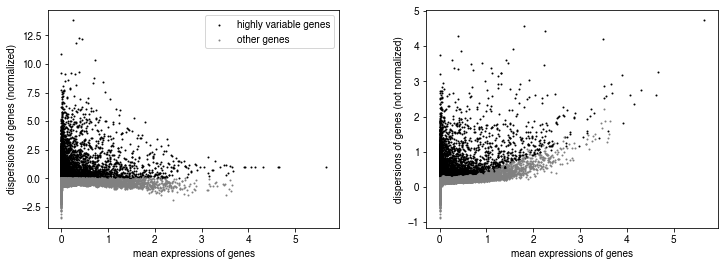

25 components passed P cutoff of 0.1.
Changing adata.obsm['X_pca'] from shape (17634, 50) to (17634, 25)


In [5]:
# basic steps of the scanpy clustering process
adata.layers['raw'] = adata.X.copy()
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, n_bins=100, n_top_genes=5000)
sc.pl.highly_variable_genes(adata)

pc_adata = adata[:, adata.var['highly_variable']].copy()
sc.pp.scale(pc_adata)
sc.tl.pca(pc_adata)
# choose significant components
n_components = significant_pc_test(pc_adata, p_cutoff=0.1, update=True)
# use raw counts to generate pseudo cell
adata.obsm['X_pca'] = pc_adata.obsm['X_pca']

# put back the raw matrix
adata.X = adata.layers['raw']
del adata.layers['raw']
del adata.uns['log1p']  # because X back to raw, delect log1p record

### Check the PCs

Red axis labels are used PCs


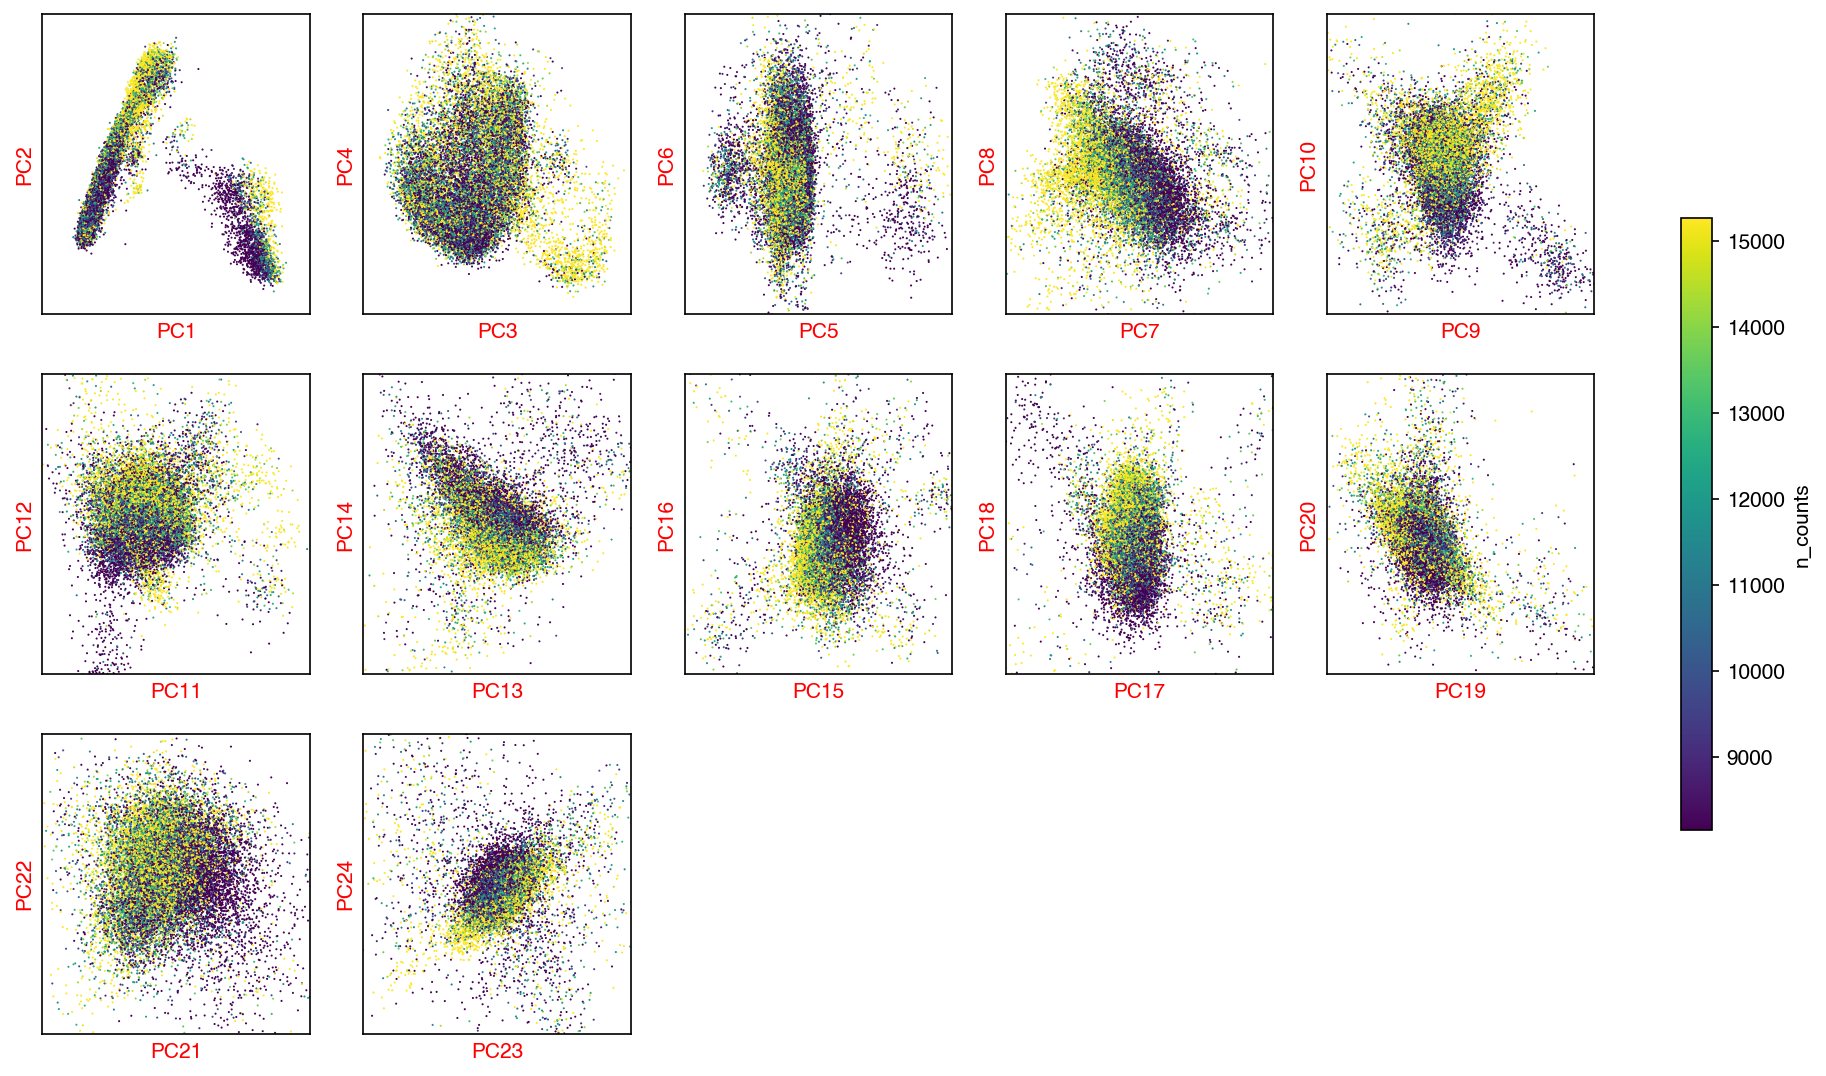

In [6]:
hue = 'n_counts'
fig, axes = plot_decomp_scatters(adata,
                                 n_components=n_components,
                                 hue=hue,
                                 hue_quantile=(0.25, 0.75),
                                 nrows=5,
                                 ncols=5)

### Downsample and balance each cluster
In this step, we group the `obsm` matrix by `cluster_col`, and run K-means on each cluster's matrix. For large clusters that have > `cluster_size_cutoff` number of cells, the K-means clustering is done iteratively until all the clusters are smaller than `max_pseudo_size`. The reducing function `aggregate_func` can be:
- `sum`: if the `adata.X` is raw counts matrix and you want to add them together to form a pseudo-cell
- `mean`: take the mean of each K-means cell group
- `median`: take the mean of each K-means cell group
- `downsample`: randomly select only one cell from the K-means cell group.

Notes:
- Here I used the cluster labels generated by the data provider, which is more granular than the leiden clusters because these labels are calculated with other brain datasets in a iterative process.
- If such labels don't exist, you may use just the leiden clusters above

In [7]:
from ALLCools.pseudo_cell import generate_pseudo_cells_kmeans

pseudo_adata = generate_pseudo_cells_kmeans(adata,
                                            cluster_col='SubType',
                                            obsm='X_pca',
                                            cluster_size_cutoff=50,
                                            max_pseudo_size=30,
                                            aggregate_func='downsample')

pseudo_adata

AnnData object with n_obs × n_vars = 3679 × 17829
    obs: 'n_cells', 'SubType'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'

## Identify HVF for integration

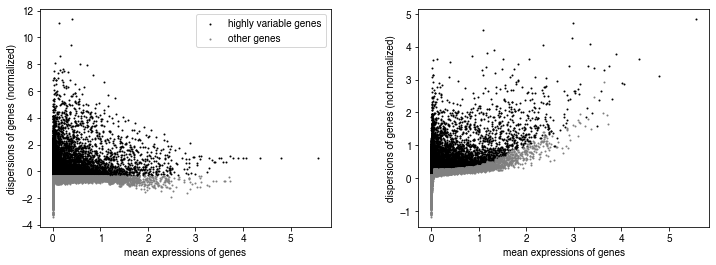

In [8]:
# identify highly variable genes on pseudo_adata
sc.pp.normalize_per_cell(pseudo_adata)
sc.pp.log1p(pseudo_adata)

sc.pp.highly_variable_genes(pseudo_adata, n_top_genes=10000, n_bins=100)
sc.pl.highly_variable_genes(pseudo_adata)
test_adata = pseudo_adata[:, pseudo_adata.var['highly_variable']].copy()

In [9]:
# remove low cov gene
sc.pp.normalize_per_cell(adata)
sc.pp.log1p(adata)

## Save AnnData

In [10]:
# this is the total adata without downsample
adata.write_h5ad(f'10X.TotalAdata.norm_log1p.h5ad')

... storing 'pseudo_group' as categorical


In [11]:
adata

AnnData object with n_obs × n_vars = 17634 × 17829
    obs: 'MajorType', 'SubType', 'n_genes', 'n_counts', 'pseudo_group'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'log1p'
    obsm: 'X_pca'

In [12]:
pseudo_adata.write_h5ad(f'10X.PseudoCellAdata.norm_log1p.h5ad')

... storing 'SubType' as categorical


In [13]:
pseudo_adata

AnnData object with n_obs × n_vars = 3679 × 17829
    obs: 'n_cells', 'SubType', 'n_counts'
    var: 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'log1p', 'hvg'

## Run a test clustering with HVFs on downsampled dataset
Run a test clustering within this dataset to check how diverse the HVF matrix is.

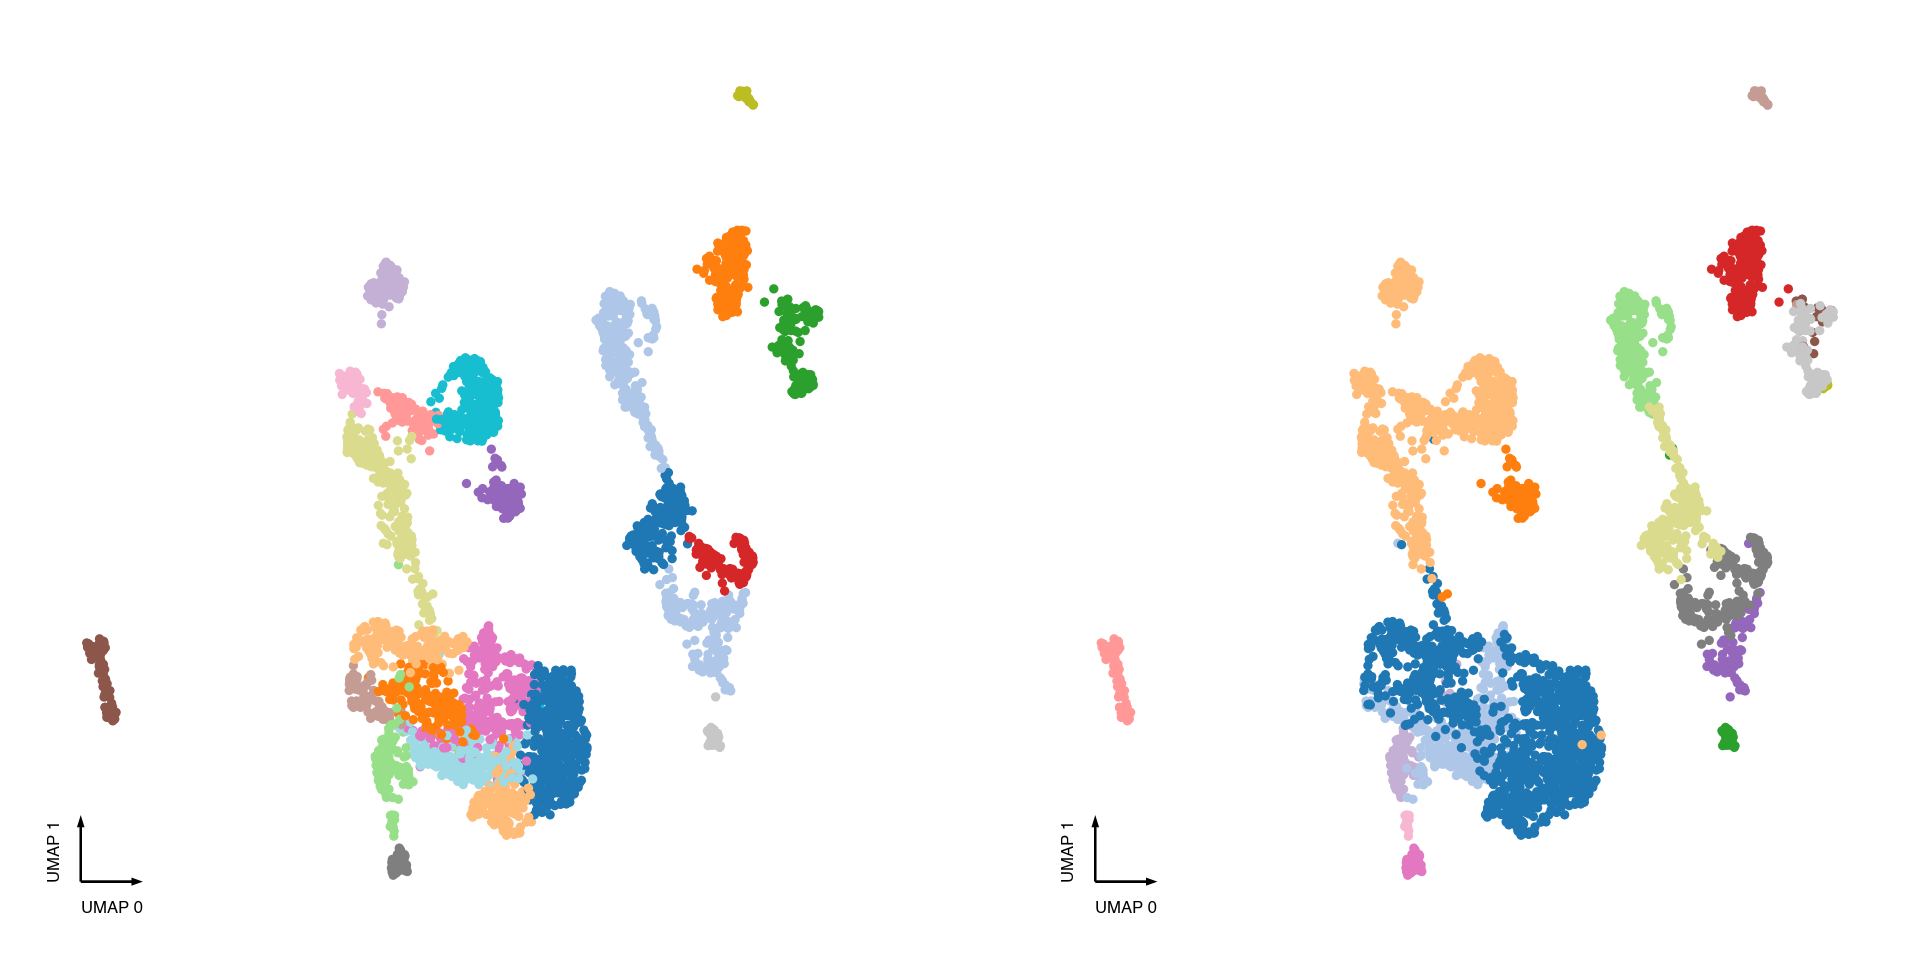

In [14]:
sc.pp.scale(test_adata)
sc.tl.pca(test_adata)
sc.pp.neighbors(test_adata)
sc.tl.umap(test_adata)
sc.tl.leiden(test_adata)
test_adata.obs['MajorType'] = test_adata.obs['SubType'].str.split('_').str[-1]

fig, axes = plt.subplots(figsize=(8, 4), dpi=300, ncols=2)
ax = axes[0]
categorical_scatter(ax=ax, data=test_adata, hue='leiden', palette='tab20')
ax = axes[1]
categorical_scatter(ax=ax, data=test_adata, hue='MajorType', palette='tab20')